In [1]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

tcmalloc: large alloc 1073750016 bytes == 0x59212000 @  0x7f8a096f32a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641


In [0]:
import torch

In [0]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt

In [7]:
use_gpu = torch.cuda.is_available()
print(use_gpu)

True


In [0]:
torch.manual_seed(42)
if(use_gpu):
  torch.cuda.manual_seed(42)

In [9]:
train_dataset = datasets.CIFAR10('data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.CIFAR10('data', train=False, transform=transforms.ToTensor(), download=True)

Files already downloaded and verified


In [0]:
batch_size = 100
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

In [0]:
CLASSES = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [12]:
for data, target in train_loader:
  print(data.size(), target.size(), len(train_loader))
  break

torch.Size([100, 3, 32, 32]) torch.Size([100]) 500


In [0]:
class Net(nn.Module):
  def __init__(self, pool_type = 'max'):
    super(Net, self).__init__()
    # Convolution 1
    self.cnn1 = nn.Conv2d(in_channels=3, out_channels=20, kernel_size=5, stride=1, padding=0)
    self.relu1 = nn.ReLU()
         
    # pool 1
    if pool_type == 'max':
      self.pool1 = nn.MaxPool2d(kernel_size=2)
    else:
      self.pool1 = nn.AvgPool2d(kernel_size=2)
      
    # Convolution 2
    self.cnn2 = nn.Conv2d(in_channels=20, out_channels=32, kernel_size=5, stride=1, padding=0)
    self.relu2 = nn.ReLU()
         
    # pool 2
    if pool_type == 'max':
      self.pool2 = nn.MaxPool2d(kernel_size=2)
    else:
      self.pool2 = nn.AvgPool2d(kernel_size=2)
         
    # Fully connected 1 (readout)
    self.fc1 = nn.Linear(32 * 5 * 5, 10)
    
   
  
  def forward(self, x):
    x = self.cnn1(x)
    x = self.relu1(x)
    x = self.pool1(x)
    x = self.cnn2(x)   
    x = self.relu2(x)
    x = self.pool2(x)
    x = x.view(x.size(0), -1)
    x = self.fc1(x)
    return x

In [0]:
pool = 'max'
model = Net(pool)
if use_gpu:
  model.cuda()

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [0]:
class ConvModel():
  def __init__(self, model):
    super(ConvModel,self).__init__()
    self.model = model
    
  def train(self, epoch, log_interval = 100):
    model.train()
    
    for batch_idx, (image,target) in enumerate(train_loader):
      if use_gpu:
        image, target = image.cuda(), target.cuda()
      image, target = Variable(image), Variable(target)
      
      optimizer.zero_grad()
      output = model.forward(image)
      loss = criterion(output, target)
      loss.backward()
      optimizer.step()
      
      if batch_idx % log_interval == 0:
        print('Train Epoch:{}, Train Loss: {:.6f}'.format(epoch, loss.data[0]))
    
  
  def test(self):
    model.eval()
    test_loss, correct = 0, 0
    loss_per_epoch = []
    Accuracy_per_epoch = []
  
    for image, target in test_loader:
      if use_gpu:
        image, target = image.cuda(), target.cuda()
        image, target = Variable(image), Variable(target)
    
      output = model(image)
      loss = criterion(output, target)
      prediction = output.data.max(1)[1]
      test_loss += criterion(output, target).data[0]
      correct += prediction.eq(target.data).sum()
    
    Average_loss = test_loss/len(test_loader)
    loss_per_epoch.append(Average_loss)
    Accuracy = 100. * correct/len(test_loader.dataset)
    Accuracy_per_epoch.append(Accuracy)
    
    
    print('Average Loss: {} , Accuracy: {} %:'.format(Average_loss, Accuracy))
    return loss_per_epoch, Accuracy_per_epoch

In [17]:
lossv = []
accv = []
conv_model = ConvModel(model)

epochs = 10
for epoch in range(1, epochs+1):
  conv_model.train(epoch)
  l, a = conv_model.test()
  lossv.append(l)
  accv.append(a)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Train Epoch:1, Train Loss: 2.321357
Train Epoch:1, Train Loss: 2.298144
Train Epoch:1, Train Loss: 2.285827
Train Epoch:1, Train Loss: 2.241773
Train Epoch:1, Train Loss: 2.150079


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Average Loss: 2.0611934661865234 , Accuracy: 26 %:
Train Epoch:2, Train Loss: 2.086584
Train Epoch:2, Train Loss: 2.015258
Train Epoch:2, Train Loss: 1.950945
Train Epoch:2, Train Loss: 1.905607
Train Epoch:2, Train Loss: 1.855226
Average Loss: 1.8458800315856934 , Accuracy: 34 %:
Train Epoch:3, Train Loss: 1.808609
Train Epoch:3, Train Loss: 1.866821
Train Epoch:3, Train Loss: 1.701454
Train Epoch:3, Train Loss: 1.869560
Train Epoch:3, Train Loss: 1.681844
Average Loss: 1.6958338022232056 , Accuracy: 40 %:
Train Epoch:4, Train Loss: 1.586863
Train Epoch:4, Train Loss: 1.663669
Train Epoch:4, Train Loss: 1.714777
Train Epoch:4, Train Loss: 1.746725
Train Epoch:4, Train Loss: 1.524014
Average Loss: 1.5831317901611328 , Accuracy: 43 %:
Train Epoch:5, Train Loss: 1.548395
Train Epoch:5, Train Loss: 1.594339
Train Epoch:5, Train Loss: 1.388761
Train Epoch:5, Train Loss: 1.671120
Train Epoch:5, Train Loss: 1.548410
Average Loss: 1.524013638496399 , Accuracy: 45 %:
Train Epoch:6, Train Loss:

In [18]:
for x in model.children():
  print(x)
print('********')
for y in model.modules():
  print(y)

Conv2d(3, 20, kernel_size=(5, 5), stride=(1, 1))
ReLU()
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d(20, 32, kernel_size=(5, 5), stride=(1, 1))
ReLU()
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Linear(in_features=800, out_features=10, bias=True)
********
Net(
  (cnn1): Conv2d(3, 20, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(20, 32, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=800, out_features=10, bias=True)
)
Conv2d(3, 20, kernel_size=(5, 5), stride=(1, 1))
ReLU()
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d(20, 32, kernel_size=(5, 5), stride=(1, 1))
ReLU()
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Linear(in_features

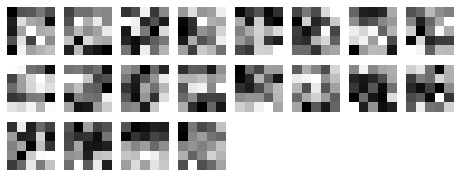

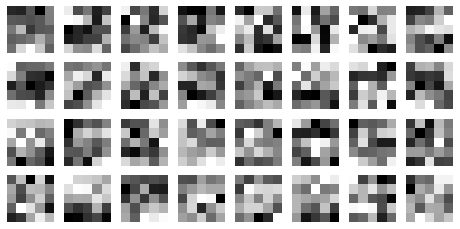

In [20]:
def plot_kernels(tensor, num_cols=6):
    num_kernels = tensor.shape[0]
    num_rows = 1+ num_kernels // num_cols
    fig = plt.figure(figsize=(num_cols,num_rows))
    for i in range(num_kernels):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        ax1.imshow(tensor[i][0,:,:], cmap='gray')
        ax1.axis('off')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()


filters = model.modules()
model_layers = [i for i in model.children()]
first_layer = model_layers[0]
second_layer = model_layers[3]

first_kernels = first_layer.weight.data.cpu().numpy()
plot_kernels(first_kernels, 8)

second_kernels = second_layer.weight.data.cpu().numpy()
plot_kernels(second_kernels, 8)
